# **ECON 323 Final Project**
## **Flight Weather Delay Classifier**


Author: Daniel Lee




Picture this. it's spring time in New York, and you, a businessman in NYC, have a flight scheduled tomorrow morning. You are slightly bothered by the fact that the company booked you a 6am flight to attend the conference happening in the West Coast, but it's a free flight, so you can only complain so much. You get up the next morning, and rush to the airport to make sure that you have ample space in time to go through the boarding procedures prior to the flight. Weather's been alright this week, so you're not expecting any delay. You finally make it to the gate, thinking that you'll be on board straight away; Then you hear the announcement from the carrier that there's going to be a delay due to weather. 10 minutes, 20 minutes and 30 minutes pass, and you're starting to get rattled by the fact that you could have gotten the breakfast AND coffee on the way, had you known that there was going to be a delay.

Weather accounts for significant portion of flight delays; one could tell that the weather delays occur when there's a heavy snowfall or rainfall, or thunderstorm. However, there certainly are delays happening, time and time again, when you think that the weather's just fine, and you always end up wasting time at the gate.

How can we tell if there's going to be a delay or not based on the live weather data? 
Following study will take a closer look into predictive modeling on weather delays happened at three airports (Newark New jersey, Logan Boston and San Francisco Airports) over April and May, 2019.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
#Install requests
!pip install requests

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-gdn6mfqr
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-gdn6mfqr
     |████████████████████████████████| 14.8MB 324kB/s 
     |████████████████████████████████| 6.5MB 51.2MB/s 
  Created wheel for geopandas: filename=geopandas-0.8.0+73.g1ef9242-py2.py3-none-any.whl size=973544 sha256=70ae08904f0649dd0858826a4a5cee4beaaa2621233008cceae8554e93781995
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlnkr2ms/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests
import seaborn as sns
import math
import random
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network

Data sources used are:

*   2019-05 US Airport On-Time Performance Data
*   2019-04 US Airport On-Time Performance Data
*   Global Airport Database 
*   WeatherSource OnPoint API - fetches historical weather Data based on postal code



In [ ]:
#Read global airport database text file, which gives the locational and geographical reference
LocDf = pd.read_csv(r"/content/gdrive/MyDrive/GlobalAirportDatabase.txt", sep=':',header = None)

LocDf.columns = ['ICAO Code', 
                 'IATA Code',	
                 'Airport Name',	
                 'City/Town',
                 'Country',	
                 'Latitude Degrees',	
                 'Latitude Minutes',	
                 'Latitude Seconds',
                 'Latitude Direction',
                 'Longitude Degrees',
                 'Longitude Minutes',
                 'Longitude Seconds',
                 'Longitude Direction',
                 'Altitude',
                 'Latitude',
                 'Longitude']

#Querying it to USA-only, airport codes and Altitude, latitude and longitude
LocDf_US = LocDf.loc[LocDf["Country"] == "USA"]

LocDf_US = LocDf_US[["IATA Code","Altitude","Latitude","Longitude"]]

LocDf_US

,IATA Code,Altitude,Latitude,Longitude
3380,ABI,546,32.411,-99.682
3381,ABQ,0,0.000,0.000
3382,ACK,15,41.253,-70.060
3383,ACT,158,31.611,-97.230
3384,ACY,23,39.458,-74.577
...,...,...,...,...
6672,NaN,0,0.000,0.000
6673,NaN,0,0.000,0.000
6674,NaN,0,0.000,0.000
6685,OLI,5,70.499,-149.879


In [ ]:
#Importing Datasets
#Carrier Performance Data
df = pd.read_csv('/content/gdrive/MyDrive/US_Carrier_2019_04.csv')
df2 = pd.read_csv('/content/gdrive/MyDrive/US_Carrier_2019_05.csv')
#Airport Weather queried from WeatherSource.com via OnPoint API
AirportWeather_A = pd.read_csv('/content/gdrive/MyDrive/AirportWeather_A.csv')
#Zip Code for all the major US Airports 
ZipCode = pd.read_csv(r"/content/gdrive/MyDrive/USAirports_ZipCode.txt", sep=',')
df = pd.merge(df,LocDf_US,how= 'left', left_on = 'ORIGIN', right_on = 'IATA Code')
df2 = pd.merge(df2,LocDf_US,how= 'left', left_on = 'ORIGIN', right_on = 'IATA Code')

In [ ]:
#Merging airport codes with its corresponding zip codes
DF = df.append(df2)
#Exclude Alaska and Hawaii
a = ["AK","HI"]
DF = DF[~DF['DEST_STATE_ABR'].isin(a)]
DF_Large = DF.copy()

DF = pd.merge(DF, ZipCode, on= 'IATA Code', how = 'right')

AirportWeather_A

,postal_code,country,timestamp,date,time,cldCvr,dewPt,feelsLike,heatIndex,mslPres,precip,presTend,radSolar,relHum,sfcPres,snowfall,spcHum,temp,windChill,windDir,windDir80m,windDir100m,windSpd,windSpd80m,windSpd100m,wetBulb
0,7114,US,2019-03-31T20:00:00-04:00,2019-03-31,2000,0,27.1,39.9,44.5,1011.8,0.0,0.9,0.0,50.4,1010.3,0,3.1,44.5,39.9,312.5,317.8,319.8,8.2,19.5,19.9,38.3
1,7114,US,2019-03-31T21:00:00-04:00,2019-03-31,2100,0,25.8,38.5,43.5,1012.9,0.0,0.9,0.0,49.3,1011.2,0,2.9,43.5,38.5,319.7,314.5,315.8,9.0,17.1,17.5,37.4
2,7114,US,2019-03-31T22:00:00-04:00,2019-03-31,2200,0,25.8,36.3,41.9,1013.6,0.0,0.8,0.0,52.3,1012.0,0,2.9,41.9,36.3,308.6,311.9,312.9,9.2,19.1,19.7,36.3
3,7114,US,2019-03-31T23:00:00-04:00,2019-03-31,2300,0,24.3,33.9,40.2,1014.2,0.0,0.7,0.0,53.3,1012.8,0,2.8,40.2,33.9,303.9,305.9,310.9,9.8,18.5,19.7,34.9
4,7114,US,2019-04-01T00:00:00-04:00,2019-04-01,0,2,22.3,32.8,39.4,1014.9,0.0,0.9,0.0,50.1,1013.6,0,2.5,39.4,32.8,300.6,305.8,307.8,10.2,20.8,21.1,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2128,US,2019-04-30T15:00:00-04:00,2019-04-30,1500,100,43.0,45.0,47.5,1024.4,0.0,0.5,329.9,84.4,1022.6,0,5.8,47.5,45.0,331.3,330.2,329.6,5.4,6.5,7.2,45.3
2924,2128,US,2019-04-30T16:00:00-04:00,2019-04-30,1600,85,42.5,46.7,49.2,1024.9,0.0,0.2,293.7,78.0,1022.8,0,5.7,49.2,46.7,322.3,324.5,329.2,6.0,9.0,8.9,45.9
2925,2128,US,2019-04-30T17:00:00-04:00,2019-04-30,1700,79,42.5,48.1,50.1,1024.7,0.0,0.4,245.2,75.1,1023.2,0,5.7,50.1,48.1,312.0,324.0,327.1,5.3,9.0,9.7,46.4
2926,2128,US,2019-04-30T18:00:00-04:00,2019-04-30,1800,89,42.4,49.7,51.5,1025.3,0.0,0.4,104.4,71.2,1023.6,0,5.6,51.5,49.7,314.1,322.2,328.1,5.6,10.9,10.8,47.1


The reason why I picked only three airports (two in the east, and one in the west) performance over April and May is because I'm looking for a delay specifically caused by weather. Spring time has the least variability in terms of extremity of weather, meaning that the climate is relatively temperate and  chances of extreme weather conditions like snowfall and heavy rainfall happening are slim. 

I specifically sampled data from Newark over the months of April and May, Logan over April and San Francisco over May. We're not interested in the CarrierDelay, LateAircraftDelay and SecurityDelays, even though one cannot completely ignore the their dependencies to weather; for the simplicity of the study, I'm only interested looking at the combined NASDelay and WeatherDelay. 

According to BTS, the provider of the airport performance data, NASDelays are collectively constituted by non-extreme weather, traffics, closed runways and etc. By nature, it is hard to locate what caused NAS Delay on a given occansion. However, BTS provides the percentage breakdown of NAS Delay causes by month, per airport. This led me to believe that, if by any chance, there is a month where ideally 100% of the NAS Delays are attributed to the non-extreme weather, I can sample those points for the completeness of the study.
Extreme weathers reportedly only covers  fraction of delays caused by the weather. For the sake of having enough sample size, the sampled non-extreme weather delays can be appended to the observations of extreme weather delays. 

The aforementioned airports on their selected months showed over 95% contributions by weather on their NAS delays. Ideally, we want 100% pure results as our response variable, but since this is a classification model instead of regression, I decided to include the NAS Delays into preparing the response variable.

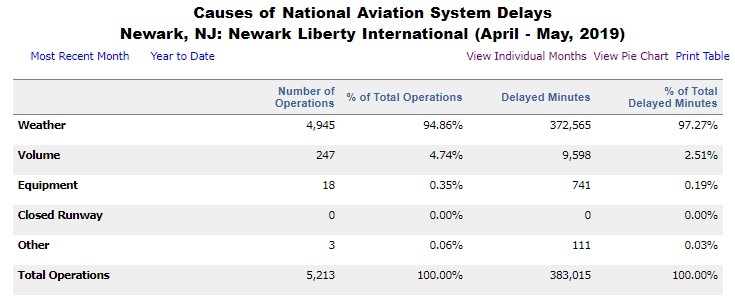

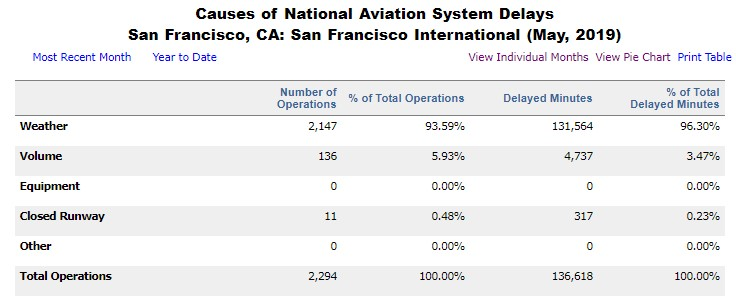

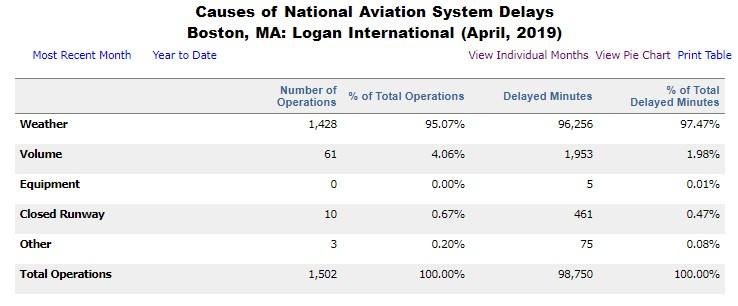

In [ ]:
#Subsetting EWR(Newark),BOS(Logan) and SFO(San Francisco)
DF_EWR = DF[DF['ORIGIN'] == 'EWR'] 
DF_BOS = DF[(DF['ORIGIN'] == 'BOS') & (DF['MONTH'] == 4)]
DF_SFO = DF[(DF['ORIGIN'] == 'SFO') & (DF['MONTH'] == 5)]

DF_A = DF_EWR.append([DF_SFO,DF_BOS])
#When the Departure delay is higher than arrival delay, it means that 
#there is NO delay happened at the arrival airport, and that flight time
#may have recovered some of the delays happened at the point of departure.
#Since we want to narrow down to the effects of weather on departure not arrival, 
#I only take the instances where departure delay is higher than that of arrival.
DF_A['HigherDelayHappened'] = DF_A['DEP_DELAY'] - DF_A['ARR_DELAY']
DF_A['HigherDelayHappened'] = DF_A['HigherDelayHappened'].apply(lambda x: 'D' if x >= 0 else 'A')

#Take random instances (850) where departure delay was less than 10 minutes (NO DELAY class)
DF_B = DF_A[(DF_A["DEP_DELAY"] < 10) & (DF_A["DEP_DELAY"] >= 0) & (DF_A["HigherDelayHappened"] == "D")]
DF_B= DF_B.sample(750)
#Take instances where arrival delay was larger or equal to 15(DELAY class)
DF_Filtered = DF_A[(DF_A["ARR_DELAY"] >= 15) & (DF_A["HigherDelayHappened"] == "D")] 
#For delay class, only take instances where it had non-extreme weather delays (NAS) or extreme weather delays (WEATHER)
DF_Filtered = DF_Filtered[(DF_Filtered["WEATHER_DELAY"] != 0) | (DF_Filtered["NAS_DELAY"] != 0)]

#Combine observations of both classes together
DF_Filtered = DF_Filtered.append(DF_B)

#Fill NA w/ Zeros
DF_Filtered = DF_Filtered.fillna(0)


Below is feature engineering:


*   A - Get Departure Weather Delays
*   B - Adjust corresponding hourly weather per location to a rounded schduled departure time of half-hour mark: Weathers change every minute and every hour. This is the next best attempt to match closest weather data per departure time, after weight-averaging weather observations by minutes between hours.
*   C - New Variable for potential improvement in  prediction: WindDirTravelDeviation





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in remainder


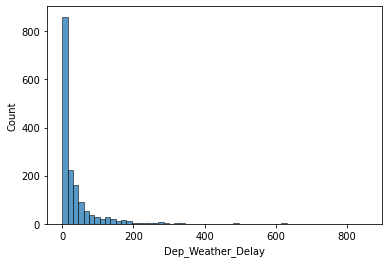

In [ ]:
#A
DF_Filtered['Arr_NonWeather_Delay'] = DF_Filtered['LATE_AIRCRAFT_DELAY'] + DF_Filtered['SECURITY_DELAY'] + DF_Filtered['CARRIER_DELAY']
DF_Filtered['Arr_Weather_Delay']  = DF_Filtered['NAS_DELAY'] + DF_Filtered['WEATHER_DELAY']
DF_Filtered['Dep_NonWeather_Delay'] = DF_Filtered['Arr_NonWeather_Delay']

for index,row in DF_Filtered.iterrows():
  DF_Filtered.loc[index,'Dep_Weather_Delay'] = row['DEP_DELAY'] - row['Arr_NonWeather_Delay']

PredictCol1 = ["FL_DATE", "OP_UNIQUE_CARRIER", "Altitude", "Latitude", "Longitude", "PostalCode", "ORIGIN", "ORIGIN_CITY_NAME","DEST", "DEST_CITY_NAME", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY",	"DEP_DELAY_NEW",	"DEP_DEL15","DEP_DELAY_GROUP",	"DEP_TIME_BLK",	
             "TAXI_OUT",	"WHEELS_OFF",	"WHEELS_ON",	"TAXI_IN", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "ARR_DELAY_NEW", "ARR_DEL15", "ARR_DELAY_GROUP",	"ARR_TIME_BLK",	"CANCELLED", "DIVERTED",	"CRS_ELAPSED_TIME",	
             "ACTUAL_ELAPSED_TIME", "AIR_TIME", "FLIGHTS", "DISTANCE", "DISTANCE_GROUP", "Arr_NonWeather_Delay", "Arr_Weather_Delay", "Dep_NonWeather_Delay", "Dep_Weather_Delay","HigherDelayHappened"]
DF_Filtered = DF_Filtered[PredictCol1]

#B
for index,row in DF_Filtered.iterrows():
  if row['CRS_DEP_TIME'] % 100 >= 31:
    DF_Filtered.loc[index,'DEP_TIME_WEATHER'] = row['CRS_DEP_TIME'] - (row['CRS_DEP_TIME'] % 100) + 100
  elif row['CRS_DEP_TIME'] % 100 <= 30:
    DF_Filtered.loc[index,'DEP_TIME_WEATHER'] = row['CRS_DEP_TIME'] - (row['CRS_DEP_TIME'] % 100)

DF_Filtered['DEP_TIME_WEATHER'] = DF_Filtered['DEP_TIME_WEATHER'].astype(int)

DF_Filtered = pd.merge(DF_Filtered, AirportWeather_A, left_on = ["FL_DATE","DEP_TIME_WEATHER","PostalCode"], right_on = ["date","time","postal_code"], how = 'left')

DF_Pred = pd.merge(DF_Filtered,LocDf_US,how = "left", left_on = "DEST", right_on = "IATA Code")

PredictCol2 = ["Dep_Weather_Delay", "ORIGIN", "DEST", "OP_UNIQUE_CARRIER", "Altitude_x", "date", "time",	"cldCvr", "dewPt", "feelsLike", "heatIndex", "mslPres", "precip", "presTend",	"radSolar", "relHum", "sfcPres", "snowfall", "spcHum",	
               "temp", "windChill", "windDir", "windDir80m", "windDir100m", "windSpd", "windSpd80m", "windSpd100m",	"wetBulb", "Latitude_x", "Longitude_x", "Latitude_y", "Longitude_y"]
DF_Pred = DF_Pred[PredictCol2]
DF_Pred

#C

y_diff = [DF_Pred['Latitude_y']-DF_Pred['Latitude_x']]
x_diff = [DF_Pred['Longitude_y']-DF_Pred['Longitude_x']]
A = np.arctan2(y_diff,x_diff).tolist()
A = np.degrees(A) % 360

def CalcGeographicAngle(arith):

  return (360 - arith + 90) % 360

A = CalcGeographicAngle(A)
A = np.concatenate(A).tolist()

DF_Pred['TravelAngle'] = A

DF_Pred['WindDirTravelDeviation'] = abs((DF_Pred['TravelAngle']-DF_Pred['windDir'])%180)


sns.histplot(DF_Pred['Dep_Weather_Delay'],binwidth= 15)



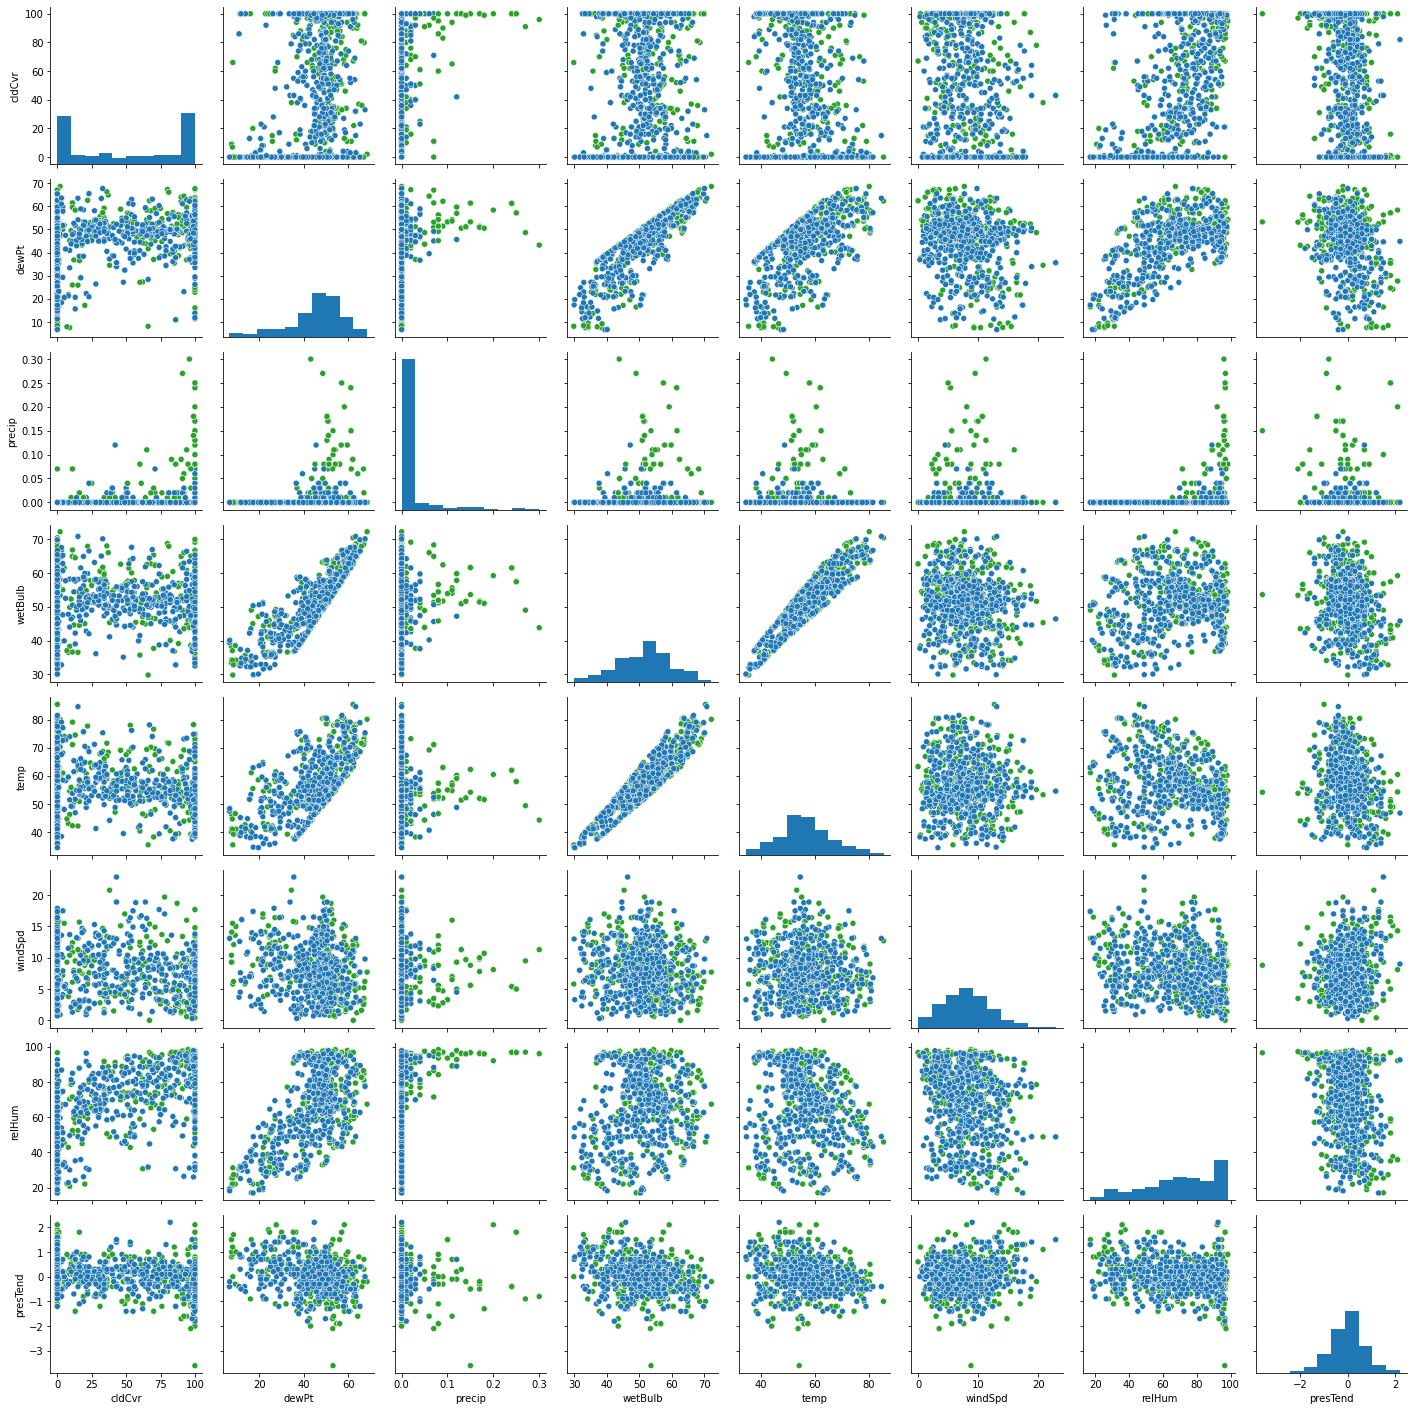

In [ ]:
#Quantiles of distribution
Q1 = DF_Pred['Dep_Weather_Delay'].quantile(0.25)
Q3 = DF_Pred['Dep_Weather_Delay'].quantile(0.75)
IQR = Q3 - Q1

#Exclude Upper Outlier
DF_Pred = DF_Pred[(DF_Pred['Dep_Weather_Delay'] <= (Q3 + 1.1 * IQR))]

DF_Pred['DelaySeverity'] = pd.cut(DF_Pred['Dep_Weather_Delay'],bins = [0,9,14,800],labels=['NoDelay','NA','Delay'])

DF_Class = DF_Pred[DF_Pred['DelaySeverity'] != "NA"]
var = DF_Class[["DelaySeverity","cldCvr", "dewPt","precip","wetBulb","temp","windSpd","relHum","presTend"]]
#Pairplots to observe colinearity
PP = sns.PairGrid(var)
PP = PP.map_diag(plt.hist)
pp = PP.map_offdiag(sns.scatterplot, hue=var['DelaySeverity'])



Looks like WetBulb and the Temp have high correlations. This might be worth taking into account when selecting our features for the prediction.

There seems to be no obvious clusters for the delay class aginst single weather variables, so ensembled methods may be more useful than single-dimension clustering.

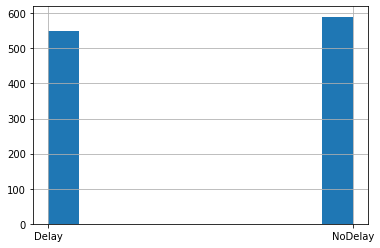

In [ ]:
DF_Class['DelaySeverity'].hist()

In [ ]:
#One Hot Encoding categorical variables for ensembe methods
from sklearn.preprocessing import OneHotEncoder
DF_Class_RF = DF_Class.dropna()

#Delay Severity as reponse variables
Y = np.array(DF_Class_RF['DelaySeverity'])
# Remove the labels from the features
DF_Class_RF = DF_Class_RF.drop('DelaySeverity', axis = 1)
DF_Class_RF = DF_Class_RF.drop('Dep_Weather_Delay', axis = 1)
# Fearue set into large, medium and small
Feature_Large = list(DF_Class_RF.columns)
Feature_Med = ["time",	"cldCvr", "dewPt", "feelsLike", "heatIndex", "mslPres", "precip", "presTend",	"radSolar", "relHum", "sfcPres", "spcHum",	
               "temp", "windChill", "windDir", "windDir80m", "windDir100m", "windSpd", "windSpd80m", "windSpd100m",	"wetBulb","TravelAngle","WindDirTravelDeviation"]
Feature_Small = ["time",	"cldCvr", "dewPt", "feelsLike", "heatIndex", "mslPres", "precip", "presTend",	"radSolar", "relHum", "sfcPres", "spcHum",	
               "temp", "windChill", "windDir", "windSpd",	"wetBulb"]
DF_Lrg_RF = pd.get_dummies(DF_Class_RF)
DF_Med_RF = DF_Class_RF[Feature_Med]
DF_Sml_RF = DF_Class_RF[Feature_Small]
# Convert to numpy array
X1 = np.array(DF_Lrg_RF)
X2 = np.array(DF_Med_RF)
X3 = np.array(DF_Sml_RF)


Below, I have divided train and test data into Large, Medium and Small depending on the # of features included.

In [ ]:

from sklearn.model_selection import train_test_split

train_features_L, test_features_L, train_labels_L, test_labels_L = train_test_split(X1, Y, test_size = 0.25, random_state = 21)
train_features_M, test_features_M, train_labels_M, test_labels_M = train_test_split(X2, Y, test_size = 0.25, random_state = 21)
train_features_S, test_features_S, train_labels_S, test_labels_S = train_test_split(X3, Y, test_size = 0.25, random_state = 21)



# **Random Forest**

In [ ]:
import sklearn.ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

def RFtuning (X_train,Y_train,X_test,Y_test):
  RF = sklearn.ensemble.RandomForestClassifier()
  #Search for best parameter
  random_grid = {
      'bootstrap': [True],
      'max_features': ['auto', 'sqrt'],
      'n_estimators': [200, 400, 600, 800, 1000]}
  rf = GridSearchCV(estimator = RF, param_grid = random_grid, cv = 3, n_jobs = -1)

  rf.fit(X_train, Y_train)

  print(f"Best Paramerter is: {rf.best_params_}")

  # All results
  means = rf.cv_results_['mean_test_score']
  stds = rf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  y_true, y_pred = Y_test, rf.predict(X_test)
  labels = np.unique(y_true)
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  print(f'Accuracy: {round(accuracy * 100.0,2)}%')
  print('Classification Report:')
  print(classification_report(y_true, y_pred))
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true,y_pred,labels = labels),index = labels, columns = labels))

RFtuning(train_features_L,train_labels_L,test_features_L,test_labels_L)

Best Paramerter is: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 800}
0.674 (+/-0.040) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 200}
0.683 (+/-0.031) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 400}
0.682 (+/-0.030) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 600}
0.682 (+/-0.033) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 800}
0.680 (+/-0.024) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 1000}
0.678 (+/-0.044) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}
0.682 (+/-0.014) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}
0.684 (+/-0.039) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 600}
0.691 (+/-0.020) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 800}
0.690 (+/-0.023) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Accuracy: 74.28%
Classification Report:
             

In [ ]:
RFtuning(train_features_M,train_labels_M,test_features_M,test_labels_M)

Best Paramerter is: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}
0.646 (+/-0.071) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 200}
0.638 (+/-0.049) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 400}
0.640 (+/-0.049) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 600}
0.645 (+/-0.050) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 800}
0.649 (+/-0.038) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 1000}
0.655 (+/-0.027) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}
0.643 (+/-0.030) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}
0.645 (+/-0.059) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 600}
0.655 (+/-0.038) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 800}
0.650 (+/-0.058) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Accuracy: 68.48%
Classification Report:
             

In [ ]:
RFtuning(train_features_S,train_labels_S,test_features_S,test_labels_S)

Best Paramerter is: {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 200}
0.650 (+/-0.070) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 200}
0.648 (+/-0.067) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 400}
0.645 (+/-0.067) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 600}
0.644 (+/-0.067) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 800}
0.649 (+/-0.063) for {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 1000}
0.645 (+/-0.067) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}
0.642 (+/-0.069) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}
0.648 (+/-0.067) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 600}
0.649 (+/-0.055) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 800}
0.640 (+/-0.069) for {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}
Accuracy: 68.12%
Classification Report:
             

# **Neural Network**

In [ ]:
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network

def NNtuning (X_train,Y_train,X_test,Y_test):
  mlp = sklearn.neural_network.MLPClassifier(max_iter=1000)
  #Neural Network search for best parameter
  parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
  }
  
  nn = sklearn.model_selection.GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
  nn.fit(X_train, Y_train)
  # Report best parameter
  print(f"Best Paramerter is: {nn.best_params_}")

  # All results
  means = nn.cv_results_['mean_test_score']
  stds = nn.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, nn.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  y_true, y_pred = Y_test, nn.predict(X_test)

  y_true, y_pred = Y_test, nn.predict(X_test)
  labels = np.unique(y_true)
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  print(f'Accuracy: {round(accuracy * 100.0,2)}%')
  print('Classification Report:')
  print(classification_report(y_true, y_pred))
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true,y_pred,labels = labels),index = labels, columns = labels))
  

NNtuning(train_features_L,train_labels_L,test_features_L,test_labels_L)

Best Paramerter is: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.592 (+/-0.037) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.562 (+/-0.035) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.602 (+/-0.039) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.605 (+/-0.028) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.580 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.576 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.

In [ ]:
NNtuning(train_features_M,train_labels_M,test_features_M,test_labels_M)

Best Paramerter is: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.585 (+/-0.075) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.577 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.585 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.591 (+/-0.036) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.599 (+/-0.040) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.600 (+/-0.032) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'ad

In [ ]:
NNtuning(train_features_S,train_labels_S,test_features_S,test_labels_S)

Best Paramerter is: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.565 (+/-0.049) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.586 (+/-0.056) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.592 (+/-0.037) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.579 (+/-0.056) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.592 (+/-0.056) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.571 (+/-0.049) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam

# **Boosted Decision Trees**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def XGBoostTuning (X_train,Y_train,X_test,Y_test):
  XGB = GradientBoostingClassifier()
  #Search for best parameter
  XG_parameter = {
    "n_estimators":[5,50,250,500],
    "max_depth":[3,7,9]
    }
  
  xgb = sklearn.model_selection.GridSearchCV(XGB, XG_parameter, cv=5)
  xgb.fit(X_train, Y_train)
  # Report best parameter
  print(f"Best Paramerter is: {xgb.best_params_}")

  # All results
  means = xgb.cv_results_['mean_test_score']
  stds = xgb.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, xgb.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  y_true, y_pred = Y_test, xgb.predict(X_test)

  y_true, y_pred = Y_test, xgb.predict(X_test)
  labels = np.unique(y_true)
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  print(f'Accuracy: {round(accuracy * 100.0,2)}%')
  print('Classification Report:')
  print(classification_report(y_true, y_pred))
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true,y_pred,labels = labels),index = labels, columns = labels))
  
XGBoostTuning(train_features_L,train_labels_L,test_features_L,test_labels_L)


Best Paramerter is: {'max_depth': 3, 'n_estimators': 50}
0.655 (+/-0.047) for {'max_depth': 3, 'n_estimators': 5}
0.711 (+/-0.054) for {'max_depth': 3, 'n_estimators': 50}
0.690 (+/-0.035) for {'max_depth': 3, 'n_estimators': 250}
0.674 (+/-0.070) for {'max_depth': 3, 'n_estimators': 500}
0.690 (+/-0.050) for {'max_depth': 7, 'n_estimators': 5}
0.691 (+/-0.037) for {'max_depth': 7, 'n_estimators': 50}
0.686 (+/-0.052) for {'max_depth': 7, 'n_estimators': 250}
0.679 (+/-0.046) for {'max_depth': 7, 'n_estimators': 500}
0.677 (+/-0.028) for {'max_depth': 9, 'n_estimators': 5}
0.678 (+/-0.029) for {'max_depth': 9, 'n_estimators': 50}
0.691 (+/-0.041) for {'max_depth': 9, 'n_estimators': 250}
0.691 (+/-0.054) for {'max_depth': 9, 'n_estimators': 500}
Accuracy: 72.1%
Classification Report:
              precision    recall  f1-score   support

       Delay       0.74      0.68      0.71       138
     NoDelay       0.70      0.76      0.73       138

    accuracy                           0.

In [ ]:
XGBoostTuning(train_features_M,train_labels_M,test_features_M,test_labels_M)

Best Paramerter is: {'max_depth': 3, 'n_estimators': 50}
0.628 (+/-0.054) for {'max_depth': 3, 'n_estimators': 5}
0.676 (+/-0.050) for {'max_depth': 3, 'n_estimators': 50}
0.640 (+/-0.033) for {'max_depth': 3, 'n_estimators': 250}
0.637 (+/-0.041) for {'max_depth': 3, 'n_estimators': 500}
0.643 (+/-0.061) for {'max_depth': 7, 'n_estimators': 5}
0.636 (+/-0.062) for {'max_depth': 7, 'n_estimators': 50}
0.616 (+/-0.042) for {'max_depth': 7, 'n_estimators': 250}
0.613 (+/-0.046) for {'max_depth': 7, 'n_estimators': 500}
0.637 (+/-0.047) for {'max_depth': 9, 'n_estimators': 5}
0.643 (+/-0.033) for {'max_depth': 9, 'n_estimators': 50}
0.619 (+/-0.052) for {'max_depth': 9, 'n_estimators': 250}
0.631 (+/-0.037) for {'max_depth': 9, 'n_estimators': 500}
Accuracy: 71.38%
Classification Report:
              precision    recall  f1-score   support

       Delay       0.75      0.64      0.69       138
     NoDelay       0.69      0.79      0.73       138

    accuracy                           0

In [ ]:
XGBoostTuning(train_features_S,train_labels_S,test_features_S,test_labels_S)

Best Paramerter is: {'max_depth': 3, 'n_estimators': 50}
0.643 (+/-0.058) for {'max_depth': 3, 'n_estimators': 5}
0.659 (+/-0.042) for {'max_depth': 3, 'n_estimators': 50}
0.631 (+/-0.028) for {'max_depth': 3, 'n_estimators': 250}
0.621 (+/-0.044) for {'max_depth': 3, 'n_estimators': 500}
0.636 (+/-0.059) for {'max_depth': 7, 'n_estimators': 5}
0.640 (+/-0.051) for {'max_depth': 7, 'n_estimators': 50}
0.643 (+/-0.048) for {'max_depth': 7, 'n_estimators': 250}
0.644 (+/-0.058) for {'max_depth': 7, 'n_estimators': 500}
0.621 (+/-0.034) for {'max_depth': 9, 'n_estimators': 5}
0.636 (+/-0.056) for {'max_depth': 9, 'n_estimators': 50}
0.640 (+/-0.056) for {'max_depth': 9, 'n_estimators': 250}
0.644 (+/-0.066) for {'max_depth': 9, 'n_estimators': 500}
Accuracy: 69.2%
Classification Report:
              precision    recall  f1-score   support

       Delay       0.76      0.57      0.65       138
     NoDelay       0.65      0.82      0.73       138

    accuracy                           0.

As seen from above, Random Forest model with the large dataset performed the best with approximately 74% accuracy on delay/non-delay prediction, closely followed by the boosted decision trees. 



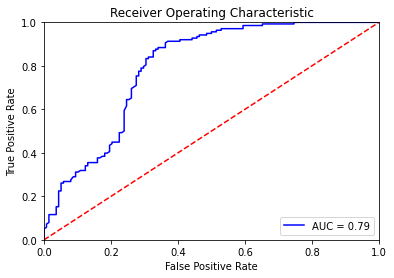

In [ ]:
# Convert to binary
test_labels_L_copy = test_labels_L.copy()
test_labels_L_copy = [1 if element == 'NoDelay' else 0 for element in test_labels_L_copy]

#Calculate probability threshold for ROC curve
rf = sklearn.ensemble.RandomForestClassifier(max_features='sqrt',n_estimators=800)
rf.fit(train_features_L,train_labels_L)
probability = rf.predict_proba(test_features_L)
prediction = probability[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_labels_L_copy, prediction)
roc_auc = sklearn.metrics.auc(fpr, tpr)

#plot
fig, ax = plt.subplots(figsize = (10,5))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As seen in the above ROC curve, the area under the curve is found to be 0.79, which is acceptable amount of disciminability in predicting correct classes.
As we want the AUC to be further close to 1, there might be some room for improvements for the prediction to better perform in the future.

Improvements can be made knowing that our classes for response variables were sampled under the assumption. We ignored the 5% offset for NAS Delay caused by non-weather related issues. Upon obtaining pure observations for response variables, where we know for sure that the sufficient amount of delays are entirely caused by weather, we may be able to improve the accuracy of the study, since our predictor variables were mostly the historical weather data.
Weather changes minute by minute, and wind especially, fluctuates every second. We held weather conditions as fixed variable at an hour mark, but ideally, a true live weather data will represent the weather correspondency at a precision of a minute. 
Challenges when predicting at such high precision with highly tailored dataset requires large amount of data and even more amount of effort in data cleaning. 

Furthermore, the study can be a building block for regression models that correctly predict the specific amount of delay caused by certain weather condition, as the study explored importance of some of the weather variables.

We looked at the delay classifiers caused by certain weather conditions. But flight delays in general, are usually standalone or combination of weather delay, carrier delay and airport delays.
One may ask, then, what airports are the most busy during non-peak season (i.e.April and May), and what airlines have the highest reputation for having the notorious carrier delays?
Figures below can maybe give preliminary insights to the question.
Below is the spatial visualization of the number of flights departed from different airports in US.

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



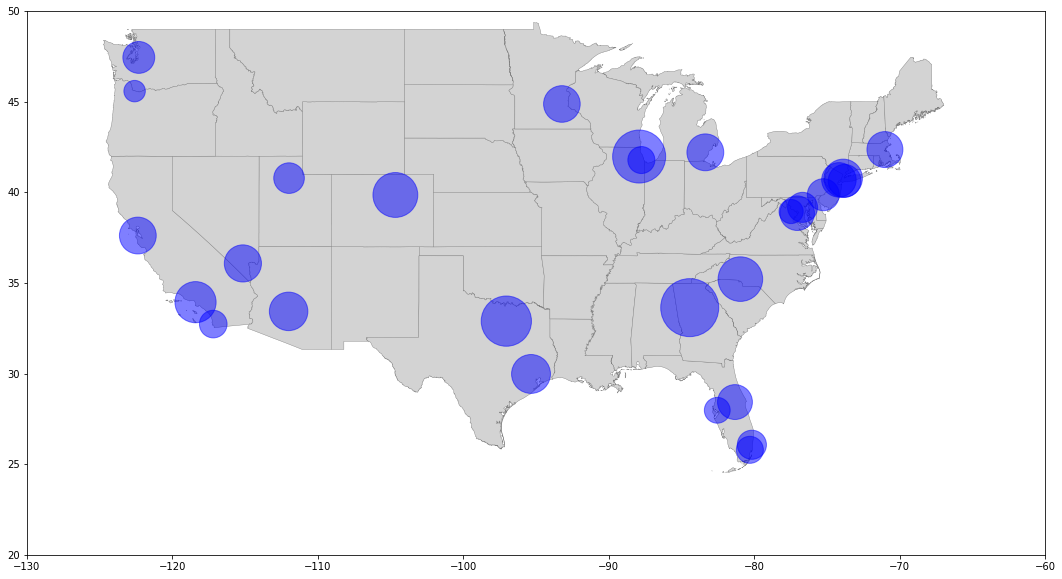

In [ ]:
DF_Summary = DF.copy()

DF_Summary['Count_Column'] = DF_Summary['ORIGIN'].map(DF_Summary['ORIGIN'].value_counts())

DF_Count = DF_Summary[["ORIGIN","Count_Column"]].drop_duplicates()
Delay_Column = ['WEATHER_DELAY','CARRIER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY']
Stats_Column = ["Sum", "Mean", "Min","Median","Max","Std"]
DF_Summary = DF_Summary.groupby("ORIGIN")[Delay_Column].agg(["sum", "mean", "min","median","max","std"]) 
DF_Summary = DF_Summary.reset_index()
DF_Summary = pd.merge(DF_Summary,DF_Count,how = 'left', on= 'ORIGIN')
DF_Summary = pd.merge(DF_Summary,LocDf_US,how = 'inner', left_on= 'ORIGIN', right_on= 'IATA Code')

DF_Summary = DF_Summary.drop(["ORIGIN"],axis = 1)
#----
New_Name = [x + y for x in Delay_Column for y in Stats_Column]
New_Name.extend(['DepartureCount','IATACode','Altitude','Latitude','Longitude'])
New_Name.insert(0,"ORIGIN")

DF_Summary.columns = New_Name
#----
states = gpd.read_file('/content/gdrive/MyDrive/US_Shape/cb_2018_us_state_500k.shp')

states.crs
#----
GeomPoints = [Point(xy) for xy in zip(DF_Summary['Longitude'],DF_Summary['Latitude'])]
GeomPoints[:3]
crs = {'init': 'epsg:4269'}
GeoDF = gpd.GeoDataFrame(DF_Summary, crs=crs, geometry=GeomPoints)
GeoDF.head()
#----
GeoDF_Copy = GeoDF.copy()
GeoDF_Copy['geometry']= GeoDF_Copy['geometry'].centroid
GeoDF_Copy
#----
fig, ax = plt.subplots(figsize = (30,10))
US_Terr = ["AS","VI","GU","MP","PR","HI","AK"]
states = states[~states['STUSPS'].isin(US_Terr)]

states.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.4)
ax.set_xlim([-130, -60])
ax.set_ylim([20,50])

GeoDF_Copy['ScaledDotSize'] = 0.05*GeoDF_Copy['DepartureCount']
GeoDF_Copy.plot(ax = ax,c='Blue', markersize='ScaledDotSize',alpha=0.5, categorical=False, legend=True)


Text(0.5, 1.0, 'Delay Instances in Major Aiports of US: April-May 2019')

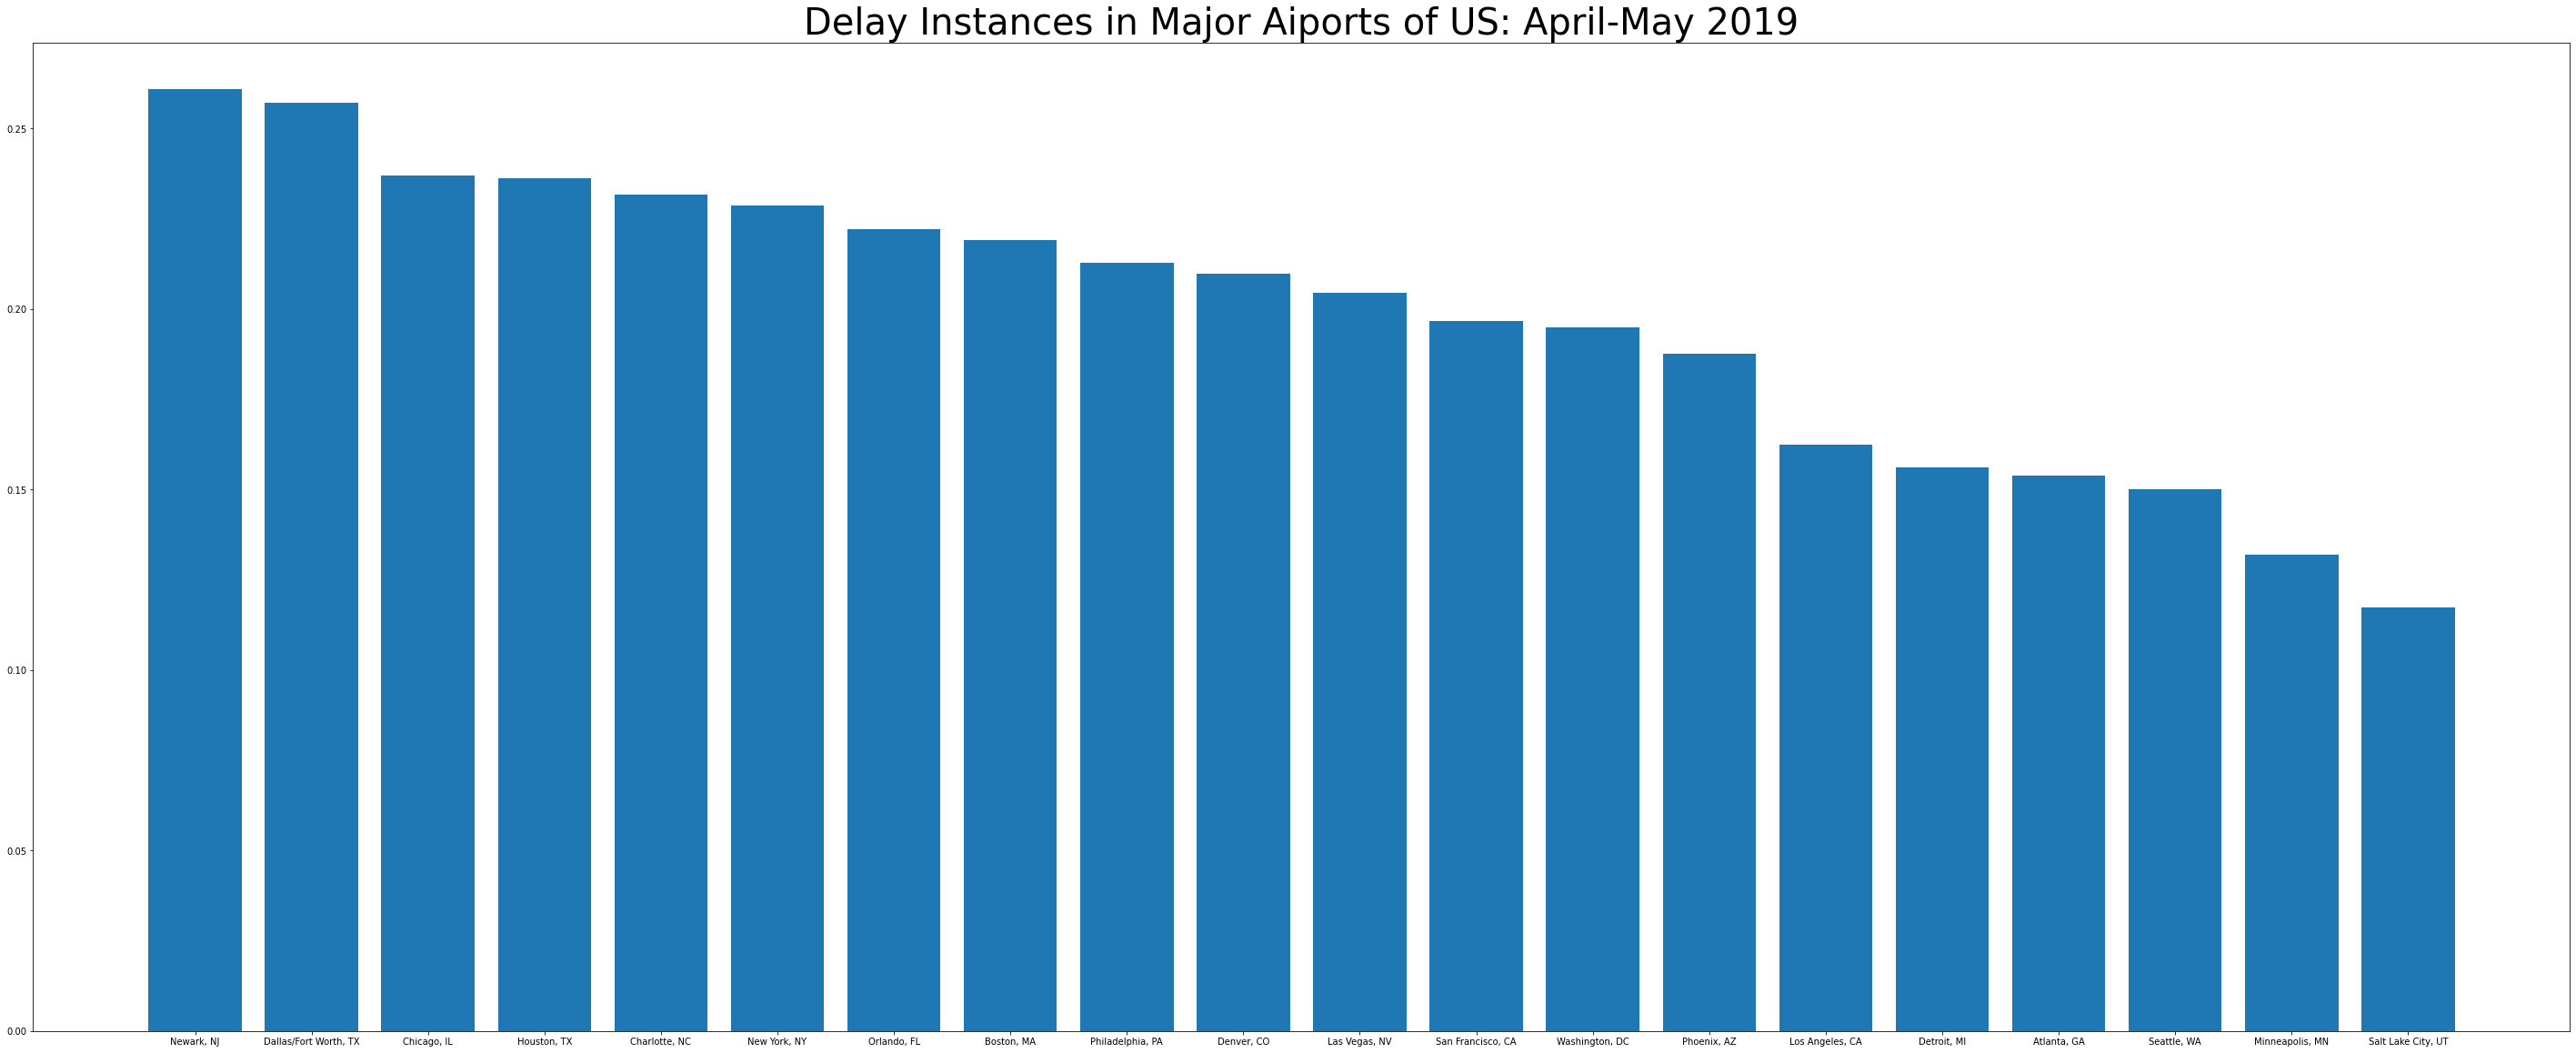

In [ ]:
DelayCount = pd.DataFrame(DF.groupby(by = ['ORIGIN_CITY_NAME'])['WEATHER_DELAY'].count())
CityCount = pd.DataFrame(DF['ORIGIN_CITY_NAME'].value_counts())

CityCount = CityCount.sort_values(by = ['ORIGIN_CITY_NAME'],ascending=False).head(20)

Count = pd.concat([DelayCount,CityCount],axis = 1)

Count['DelayRate'] = Count['WEATHER_DELAY']/Count['ORIGIN_CITY_NAME']
Count = Count.sort_values(by = ['DelayRate'],ascending=False).head(20)

a = {'fontsize': 40,
 'fontweight' : 20,
 'verticalalignment': 'baseline'}
b = {'fontsize': 10,
 'fontweight' : 20,
 'verticalalignment': 'baseline'}
fig, ax = plt.subplots(figsize=(50,20))
plt.bar(x = Count.index,height = Count['DelayRate'],)
plt.title("Delay Instances in Major Aiports of US: April-May 2019",fontdict= a)


Newark Airport in New Jersey had the most number of extreme weather delays during April and May of 2019! It means that picking the airport was a reasonable choice for the prediction modeling.

Text(0.5, 1.0, 'US Carrier Delays by Airlines: April-May 2019')

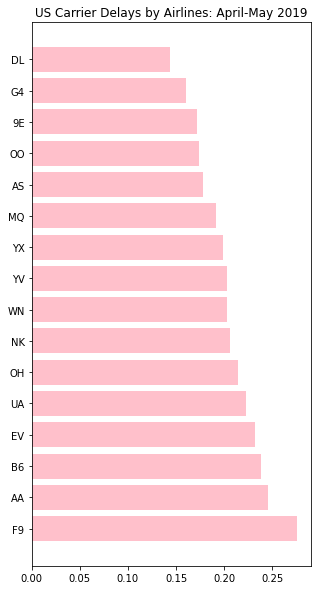

In [ ]:
CarrierDelay = pd.DataFrame(DF.groupby(by = ['OP_CARRIER'])['CARRIER_DELAY'].count())
CarrierCount = pd.DataFrame(DF['OP_CARRIER'].value_counts())

CC = pd.concat([CarrierDelay,CarrierCount],axis = 1)

CC['DelayRate'] = CC['CARRIER_DELAY']/CC['OP_CARRIER']

CC = CC.sort_values(by= ['DelayRate'],ascending=False)

fig, ax = plt.subplots(figsize=(5,10))

ax.barh(CC.index,width = CC['DelayRate'],color = 'pink', label = 'Delay Rate')
plt.title('US Carrier Delays by Airlines: April-May 2019')

Frontier Airline, American Airline and Jet Blue Airlines had the most instances of carrier delays amongst their flights in April and mAy of 2019.